## Preprocess data

In [98]:
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import pytorch_lightning as pl
from tqdm import tnrange
from collections import Counter
from evaluate import load
import bert_score
from transformers import logging
logging.set_verbosity_error()
import matplotlib.pyplot as plt
import bert_score


from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


from utils.evaluator import Evaluator, evaluate_model

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [99]:
dataset = load_dataset("xsum")

use_percent_train = 10
dataset_train = load_dataset("xsum", split=f"train[:{use_percent}%]")
dataset_val = load_dataset("xsum", split=f"validation[:{2*use_percent}%]")
dataset_test = load_dataset("xsum", split=f"test[:{2*use_percent}%]")
dataset = DatasetDict({'train': dataset_train, 'validation': dataset_val, 'test': dataset_test})

print(dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 10202
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1133
    })
})


In [3]:
example = dataset['train'][0]

print("text:", example["document"])
print("Summary:", example["summary"])
print("id:", example["id"])

text: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it

In [4]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

prefix = "summarize: "
max_input_length = 600
max_target_length = 200

def preprocessor(examples, prefix='summarize:', max_input_length=512, max_target_length=128):
  # encode the code-docstring pairs
  texts = examples['document']
  summaries = examples['summary']
  
  inputs = [prefix + text for text in texts]
  model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(summaries, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # important: we need to replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)
  
  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs

In [5]:
dataset = dataset.map(preprocessor, batched=True)
print(dataset)

Loading cached processed dataset at /home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-c3fe841e2c44f842.arrow


Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-af974ae3591383c1.arrow


DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10202
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 567
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 567
    })
})


In [6]:
dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10202
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 567
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 567
    })
})


In [7]:
num_workers = os.cpu_count()
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=8, num_workers=num_workers)
valid_dataloader = DataLoader(dataset['validation'], batch_size=4, num_workers=num_workers)
test_dataloader = DataLoader(dataset['test'], batch_size=4, num_workers=num_workers)

In [8]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [9]:
tokenizer.decode(batch['input_ids'][0])

"summarize:Cesc Fabregas marked his 300th Premier League appearance by firing the Blues ahead, poking the ball through the legs of Jack Cork and into the net. The hosts were stunned when Swansea equalised from their first serious attempt on target on the stroke of half-time - Fernando Llorente heading in Gylfi Sigurdsson's free-kick. Fabregas hit the bar before Pedro's curling effort restored the lead and Diego Costa netted the third from close range. Swansea were denied a penalty when Cesar Azpilicueta handled inside the area at 1-1. This was far from straightforward for Antonio Conte's side and had referee Neil Swarbrick awarded Swansea a penalty shortly before Pedro made it 2-1 then the outcome might have been different. However, in the end Chelsea's sweeping forward play earned them a 10th straight home Premier League win as they took another significant step towards a second title in three seasons. On a weekend when the first major silverware of the season - the EFL Cup - is hande

In [10]:
labels = batch['labels'][0]
tokenizer.decode([label for label in labels if label != -100])

'Chelsea stretched their lead at the top of the Premier League table to 11 points after victory over battling Swansea City at Stamford Bridge.</s>'

## Fine-tune using PyTorch Lightning


In [23]:
class T5(pl.LightningModule):
    def __init__(self, lr=5e-5, num_train_epochs=15, warmup_steps=1000):
        super().__init__()
        self.model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
        self.train_losses=[]
        self.validation_losses=[]

        self.train_losses_epoch=[]
        self.validation_losses_epoch=[]

        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask, labels=None):     
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs
    
    def common_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss

        return loss
      
    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.train_losses.append(loss)
        

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.validation_losses.append(loss)
        
            
        return loss

    
        
    
        return loss
    def on_train_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_train_loss = sum(self.train_losses)/ len(self.train_losses)
        self.train_losses_epoch.append(avg_train_loss.item())

        # Reset epoch loss accumulator
        self.train_losses = []

    def on_validation_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_val_loss = sum(self.validation_losses) / len(self.validation_losses)
        self.validation_losses_epoch.append(avg_val_loss.item())

        # Reset epoch loss accumulator
        self.validation_losses = []

    

        # Reset epoch loss accumulator
        self.test_losses = []
    def configure_optimizers(self):
        # create optimizer
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        # create learning rate scheduler
        num_train_optimization_steps = self.hparams.num_train_epochs * len(train_dataloader)
        lr_scheduler = {'scheduler': get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.hparams.warmup_steps,
                                                    num_training_steps=num_train_optimization_steps),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
    
    def generate(self, input_ids, max_new_tokens=30, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        input_ids=input_ids.clone().detach().reshape((1,-1)).to(device)
        return self.model.generate(input_ids)
    
    def push_to_hub(self, model_name, organization):
        # Save the model
        self.model.push_to_hub(model_name, organization)

        
    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return valid_dataloader

    def test_dataloader(self):
        return test_dataloader

In [27]:
# Hyperparameters
lr = 5e-5
num_train_epochs = 15
warmup_steps = 1000
patience = 3
max_epochs = 10

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=patience,
    strict=False,
    verbose=False,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(dirpath='./saved/saved_checkpoints/', monitor='validation_loss', mode='min', save_top_k = 1)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
trainer = Trainer(accelerator=accelerator, 
                  callbacks=[early_stop_callback, lr_monitor, checkpoint_callback], max_epochs=max_epochs)

model = T5(lr=lr, num_train_epochs=num_train_epochs, warmup_steps=warmup_steps)
trainer.fit(model)
tokenizer.save_pretrained("./saved/tokenizers/")
checkpoint_path = checkpoint_callback.best_model_path

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [28]:
train_losses=model.train_losses_epoch
validation_losses=model.validation_losses_epoch


In [29]:
print('Loss on validation set before fine tuning: ', validation_losses[0])

Loss on validation set before fine tuning:  3.6617534160614014


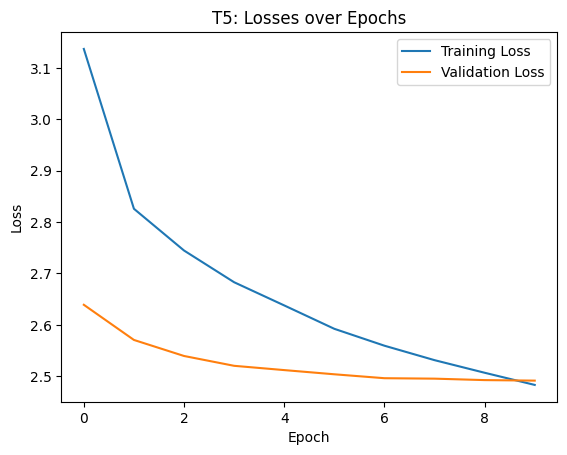

In [30]:

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses[1:], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('T5: Losses over Epochs')

# Adding legend
plt.legend()

plt.savefig('losses_plot.png')
# Displaying the plot
plt.show()

## Inference

In [11]:
test_dataset = dataset['test']
test_document = test_dataset['document'][0]
test_input_ids = test_dataset[0]['input_ids']
test_gt_summary = test_dataset['summary'][0]
test_attention_mask = test_dataset[0]['attention_mask']

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
tokenizer_save_directory="./saved/tokenizers/"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_directory)
checkpoint_path = './saved/saved_checkpoints/epoch=9-step=12760.ckpt'
new_model = T5.load_from_checkpoint(checkpoint_path, map_location=torch.device('cpu')).to(device)
new_model.eval()

T5(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_features=2048, ou

In [80]:
print("Input document:")
print(test_document)

Input document:
Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.
Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.
The Welsh Government said more people than ever were getting help to address housing problems.
Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.
Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.
However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.
Andrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the nee

In [81]:
print("Ground truth summary:")
print(test_gt_summary)

Ground truth summary:
There is a "chronic" need for more housing for prison leavers in Wales, according to a charity.


In [82]:
output_ids = new_model.generate(test_input_ids)
generated_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [83]:
print("Generated summary:")
print(generated_summary)

Generated summary:
A charity has said it is "desperate" for people to find accommodation after their release


## Evaluation

In [12]:


class Evaluator:
    def __init__(self, hypothesis, reference):
        self.hypothesis = hypothesis
        self.reference = reference
        
        self.metrics={
        'rouge1': self.rouge_N(1),
        'rouge2': self.rouge_N(2),
        'rougeL': self.rouge_L(),
        'rougeLsum': self.rouge_L_sum(),
        'bert': self.bert_Score()
    }
        
    def rouge_L(self):
        metric = load("rouge")
        metric_type = 'rougeL'
        rg_score = metric.compute(predictions=self.hypothesis, references=self.reference, rouge_types=[metric_type])[metric_type]
        print('rougeL computed')
        return rg_score
        
    
    def rouge_N(self, n=1):
        metric = load("rouge")
        metric_type = f'rouge{n}'
        rg_score = metric.compute(predictions=self.hypothesis, references=self.reference, rouge_types=[metric_type])[metric_type]
        print('rougeN computed')
        return rg_score
		
		
    def rouge_L_sum(self):
        metric = load("rouge")
        metric_type = 'rougeLsum'
        rg_score = metric.compute(predictions=self.hypothesis, references=self.reference, rouge_types=[metric_type])[metric_type]
        print('rougeLsum computed')
        return rg_score
		
        
    def bert_Score(self):
        metric = load("bertscore")
        all_preds= bert_score.score(self.hypothesis, self.reference, lang='en')
        score = {"precision": (torch.sum(all_preds[0].cpu())/all_preds[0].cpu().numel()).item(), "recall": (torch.sum(all_preds[1].cpu())/all_preds[1].cpu().numel()).item(), "f1":
                (torch.sum(all_preds[2].cpu())/all_preds[2].cpu().numel()).item()}
        print('Bert computed')
        return score
    

    
        
    
    
    def rouge_L_evaluation(self):
        # Tokenize hypothesos and reference sentences
        hypothesis_tokens = self.hypothesis.split()
        reference_tokens = self.reference.split()

        # Compute the length of the longest common subsequence
        lcs = lcs_length(hypothesis_tokens, reference_tokens)

        # Compute precision, recall, and f1 score
        precision = lcs / len(hypothesis_tokens)
        recall = lcs / len(reference_tokens)
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))

        return {"precision": precision, "recall": recall, "f1": f1_score}


    def rouge_N_evaluation(self, n=1):
        # split sentences into n-grams
        def ngrams(sentence, n):
            # use a list comprehension to generate n-grams
            return Counter([tuple(sentence[i:i+n]) for i in range(len(sentence) - n + 1)])

        # compute the n-grams for the candidate and reference sentences
        hypothesis_ngrams = ngrams(self.hypothesis.split(" "), n)
        reference_ngrams = ngrams(self.reference.split(" "), n)

        # count the number of shared n-grams
        shared_ngrams = hypothesis_ngrams & reference_ngrams
        shared_count = sum(shared_ngrams.values())

        # calculate precision, recall, and f1 score
        precision = shared_count / sum(hypothesis_ngrams.values())
        recall = shared_count / sum(reference_ngrams.values())
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))

        return {"precision": precision, "recall": recall, "f1": f1_score}
    
    def rouge_L_sum_evaluation(self):
        # Tokenize candidate and reference summaries
        hypothesis_tokens = self.hypothesis.split()
        reference_tokens = self.reference.split()

        # Compute the length of the longest common subsequence for summarizations
        lcs_sum = lcs_length(hypothesis_tokens, reference_tokens)

        # Compute precision, recall, and f1 score
        precision = lcs_sum / len(hypothesis_tokens)
        recall = lcs_sum / len(reference_tokens)
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))

        return {"precision": precision, "recall": recall, "f1": f1_score}
    
    @staticmethod
    def lcs_length(s1, s2):
            m, n = len(s1), len(s2)
            dp = [[0] * (n + 1) for _ in range(m + 1)]

            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if s1[i - 1] == s2[j - 1]:
                        dp[i][j] = dp[i - 1][j - 1] + 1
                    else:
                        dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

            return dp[m][n]
        
        
def evaluate_model(test_data, model, tokenizer, device):
        reference=[]
        candidate=[]
        for input_text_ids, summary in zip(test_data['input_ids'], test_data['summary']):
            #input_text_ids=input_text_ids.clone().detach().reshape((1,-1)).to(device)
            generated_summary = model.generate(input_text_ids)  # Generate summary using your model's generate function
            gen_summary=tokenizer.decode(generated_summary[0], skip_special_tokens=True)
            reference.append(summary)
            candidate.append(gen_summary)
        scores = Evaluator(candidate, reference).metrics
        
        return scores
    


# T5 small baseline

In [16]:
def evaluate_t5(test_data, model, tokenizer, device):
        reference=[]
        candidate=[]
        for input_text_ids, summary in zip(test_data['input_ids'], test_data['summary']):
            input_text_ids=input_text_ids.clone().detach().reshape((1,-1)).to(device)
            generated_summary = model.generate(input_text_ids)  # Generate summary using your model's generate function
            gen_summary=tokenizer.decode(generated_summary[0], skip_special_tokens=True)
            reference.append(summary)
            candidate.append(gen_summary)
        scores = Evaluator(candidate, reference).metrics
        
        return scores
    

In [13]:
t5_small=AutoModelForSeq2SeqLM.from_pretrained("t5-small")
t5_tokenizer=AutoTokenizer.from_pretrained("t5-small")

In [ ]:
scores=evaluate_t5(test_dataset, t5_small, t5_tokenizer, torch.device('cpu'))
bert_scores=scores['bert']
rouge_1_score=scores['rouge1']
rouge_2_score=scores['rouge2']
rouge_L_score=scores['rougeL']
rouge_L_sum_score=scores['rougeLsum']

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


rougeN computed
rougeN computed
rougeL computed
rougeLsum computed
Bert computed


In [18]:
print('Bert Scores: Precision ',bert_scores['precision'],'| Recall ',bert_scores['recall'],'| F1Score ',bert_scores['f1'])
print('Rouge-1 Score: ',rouge_1_score)
print('Rouge-2 Score: ',rouge_2_score)
print('Rouge-L Score: ',rouge_L_score)
print('Rouge-L-summ Score: ',rouge_L_sum_score)

Bert Scores: Precision  0.8564128279685974 | Recall  0.8485594987869263 | F1Score  0.8523361682891846
Rouge-1 Score:  0.1570067879183779
Rouge-2 Score:  0.020652532773466556
Rouge-L Score:  0.12672791563933405
Rouge-L-summ Score:  0.12672791563933405


# our fine tuned model

In [41]:
scores=evaluate_model(test_dataset, model, tokenizer, device)
bert_scores=scores['bert']
rouge_1_score=scores['rouge1']
rouge_2_score=scores['rouge2']
rouge_L_score=scores['rougeL']
rouge_L_sum_score=scores['rougeLsum']

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


rougeN computed
rougeN computed
rougeL computed
rougeLsum computed
Bert computed


In [42]:
print('Bert Scores: Precision ',bert_scores['precision'],'| Recall ',bert_scores['recall'],'| F1Score ',bert_scores['f1'])
print('Rouge-1 Score: ',rouge_1_score)
print('Rouge-2 Score: ',rouge_2_score)
print('Rouge-L Score: ',rouge_L_score)
print('Rouge-L-summ Score: ',rouge_L_sum_score)

Bert Scores: Precision  0.8793538808822632 | Recall  0.8626567721366882 | F1Score  0.8708133101463318
Rouge-1 Score:  0.25855344883223175
Rouge-2 Score:  0.06463937163946452
Rouge-L Score:  0.2058458203568525
Rouge-L-summ Score:  0.2058458203568525


## Push Model To the hub

In [43]:
from huggingface_hub import notebook_login
notebook_login()

In [44]:
new_model.push_to_hub("T5_Summarizer", organization="ZinebSN")


pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]